## Libraries

In [2]:
pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
ERROR: Operation cancelled by user
^C


In [1]:
pip install torch-geometric

  Using cached torch_geometric-2.5.3-py3-none-any.whl (1.1 MB)


In [47]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Part A

In [3]:
# Create df from dataset
edges_df = pd.read_csv(os.path.join('/content/musae_git_edges.csv'))
target_df = pd.read_csv(os.path.join('/content/musae_git_target.csv'))

In [4]:
# Check edges_df
edges_df

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982
...,...,...
288998,37527,37596
288999,37529,37601
289000,37644,2347
289001,25879,2347


In [5]:
# Check target_df
target_df

,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1
...,...,...,...
37695,37695,shawnwanderson,1
37696,37696,kris-ipeh,0
37697,37697,qpautrat,0
37698,37698,Injabie3,1


In [6]:
# Open and load the .json file
with open('/content/musae_git_features.json', 'r') as file:
    json_data = json.load(file)

# Show 1st data in .json file
list(json_data.items())[:1]

[('0',
  [1574,
   3773,
   3571,
   2672,
   2478,
   2534,
   3129,
   3077,
   1171,
   2045,
   1539,
   902,
   1532,
   2472,
   1122,
   2480,
   3098,
   2115,
   1578])]

In [7]:
# Split data to create column for each feature
data_rows = [{'id': id, **{'feature_' + str(i): feature for i, feature in enumerate(features)}}
             for id, features in json_data.items()]

In [8]:
# Create json_df for data in .json file
feature_df = pd.DataFrame(data_rows)

In [9]:
feature_df = feature_df.astype('Int64')

In [10]:
max_value = feature_df.drop(['id'], axis=1).max().max()

In [11]:
# One-hot encoding
data_encoded = []
for i, row in feature_df.iterrows():
    row_values = row.dropna().tolist()
    one_hot_feat = [0] * (max_value + 1)
    for value in row_values:
        if value <= max_value:
            one_hot_feat[value] = 1
    data_encoded.append(one_hot_feat)

In [12]:
feature_df

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,0,1574,3773,3571,2672,2478,2534,3129,3077,1171,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,1193,376,73,290,3129,1852,3077,1171,1022,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2,1574,3773,925,1728,2815,2963,3077,364,1171,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,3,3964,3773,4003,928,1852,3077,364,1022,3763,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,4,1929,3773,1793,3511,1290,3129,3077,364,1171,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37695,37695,1574,3773,73,1995,3554,1233,1789,345,3129,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
37696,37696,1929,3773,1663,1404,508,819,1852,3077,364,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
37697,37697,3433,3773,3104,1245,3129,1852,3077,364,1171,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
37698,37698,3730,3773,1695,2092,2954,1852,3077,364,1171,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [13]:
# Check encoding
data_encoded[37699][3433]

1

## Part B

In [14]:
# Count the occurrences of each class
label_counts = target_df['ml_target'].value_counts()
label_counts

ml_target
0    27961
1     9739
Name: count, dtype: int64

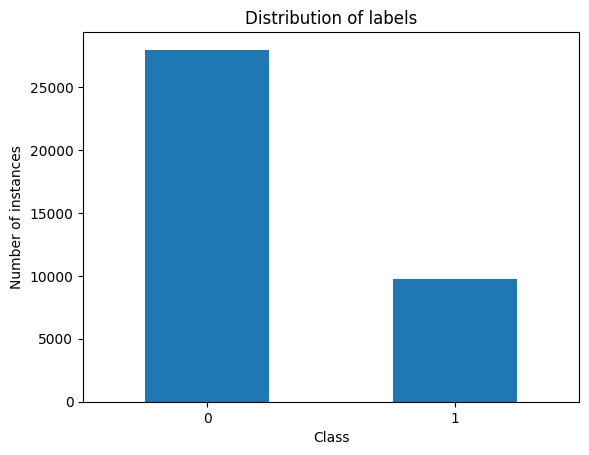

In [15]:
# Plotting the distribution
plt.figure()
label_counts.plot(kind='bar')
plt.title('Distribution of labels')
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.xticks(rotation=0)
plt.show()

## Part C

In [38]:
# Create tensor for edge, feature and target
edge_index = torch.tensor(edges_df.values.T, dtype=torch.long)
feature_tensor = torch.tensor(data_encoded, dtype=torch.float32)
label_tensor = torch.tensor(target_df['ml_target'].values, dtype=torch.long)

In [39]:
# Create Data object from tensors
data = Data(edge_index=edge_index, x=feature_tensor, y=label_tensor)

In [40]:
# Check data
data

Data(x=[37700, 4005], edge_index=[2, 289003], y=[37700])

In [80]:
# GCNN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [74]:
num_nodes = data.num_nodes

# Shuffle indices
indices = np.random.permutation(num_nodes)

# Assign 80% of indices to training, 10% to validation, 10% to testing
train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

# Add masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask


In [76]:
# Reduce imbalancing effect
counts = torch.bincount(data.y[data.train_mask])
weights = 1.0 / counts.float()
normalized_weights = weights / weights.sum()
final_weights = normalized_weights.to(torch.float32)

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=data.num_features, num_classes=torch.max(data.y)+1)
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=final_weights)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Record training loss
    train_losses.append(loss.item())

    # Calculate training accuracy
    _, pred = torch.max(out[data.train_mask], 1)
    correct = pred.eq(data.y[data.train_mask]).sum().item()
    train_accuracy = correct / data.train_mask.sum().item()
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
        val_losses.append(val_loss.item())

        # Calculate validation accuracy
        _, val_pred = torch.max(val_out[data.val_mask], 1)
        val_correct = val_pred.eq(data.y[data.val_mask]).sum().item()
        val_accuracy = val_correct / data.val_mask.sum().item()
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}, Train Acc {train_accuracy:.4f}, Val Acc {val_accuracy:.4f}')

Epoch 1: Train Loss 0.6996, Val Loss 0.6898, Train Acc 0.2771, Val Acc 0.3570
Epoch 2: Train Loss 0.6902, Val Loss 0.6823, Train Acc 0.3572, Val Acc 0.6753
Epoch 3: Train Loss 0.6825, Val Loss 0.6758, Train Acc 0.6692, Val Acc 0.7594
Epoch 4: Train Loss 0.6758, Val Loss 0.6696, Train Acc 0.7683, Val Acc 0.7801
Epoch 5: Train Loss 0.6695, Val Loss 0.6629, Train Acc 0.7874, Val Acc 0.7958
Epoch 6: Train Loss 0.6629, Val Loss 0.6556, Train Acc 0.8001, Val Acc 0.8064
Epoch 7: Train Loss 0.6557, Val Loss 0.6476, Train Acc 0.8125, Val Acc 0.8127
Epoch 8: Train Loss 0.6479, Val Loss 0.6390, Train Acc 0.8205, Val Acc 0.8210
Epoch 9: Train Loss 0.6395, Val Loss 0.6300, Train Acc 0.8289, Val Acc 0.8271
Epoch 10: Train Loss 0.6308, Val Loss 0.6208, Train Acc 0.8328, Val Acc 0.8297
Epoch 11: Train Loss 0.6220, Val Loss 0.6116, Train Acc 0.8352, Val Acc 0.8310
Epoch 12: Train Loss 0.6131, Val Loss 0.6025, Train Acc 0.8358, Val Acc 0.8329
Epoch 13: Train Loss 0.6044, Val Loss 0.5936, Train Acc 0.835

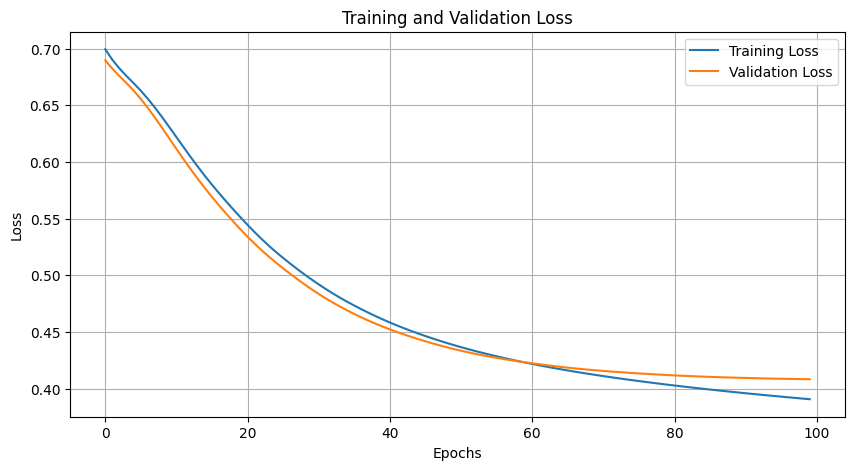

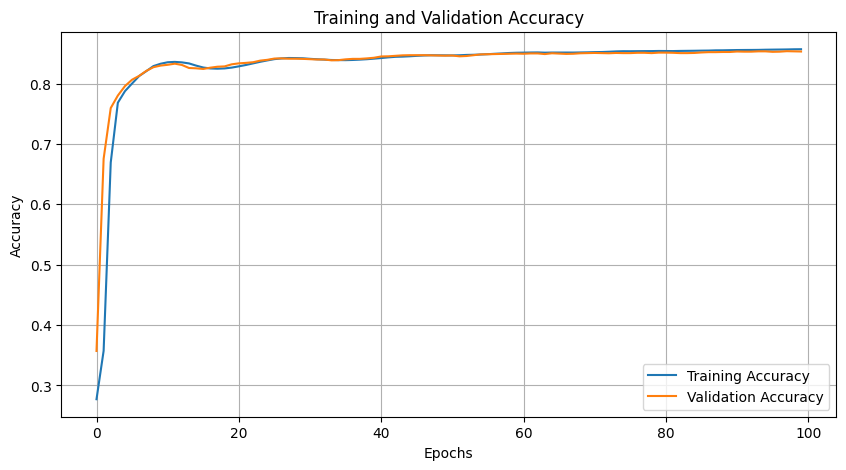

In [89]:
# Plot for losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Part D

In [91]:
model.eval()
with torch.no_grad():
    test_out = model(data)
    test_loss = criterion(test_out[data.test_mask], data.y[data.test_mask])

    # Calculate test accuracy
    _, test_pred = torch.max(test_out[data.test_mask], 1)
    test_correct = test_pred.eq(data.y[data.test_mask]).sum().item()
    test_accuracy = test_correct / data.test_mask.sum().item()

    # Calculate precision, recall, and F1 score
    test_precision = precision_score(data.y[data.test_mask].cpu(), test_pred.cpu(), average='macro')
    test_recall = recall_score(data.y[data.test_mask].cpu(), test_pred.cpu(), average='macro')
    test_f1 = f1_score(data.y[data.test_mask].cpu(), test_pred.cpu(), average='macro')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Test Loss: 0.4462
Test Accuracy: 0.8289
Test Precision: 0.7656
Test Recall: 0.8018
Test F1 Score: 0.7798
